# filter temporally surface fields

In [1]:
import os, sys
import numpy as np
import dask
import xarray as xr
from dask import delayed
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import signal
import scipy.ndimage as im

from mitequinox.utils import *
from mitequinox.plot import *
#from mitequinox.sigp import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1)
#print(cluster.job_script())
w = cluster.scale(30)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.36.67:39900 Dashboard: http://10.135.36.67:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## define the filter

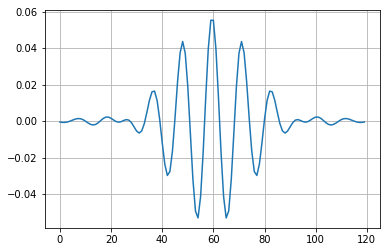

In [6]:
dt = 1. # in hours
# semidiurnal
suff, h = '_semid', signal.firwin(24*5, cutoff=[1./14.,1./10.], 
                                  pass_zero=False, nyq=1./2/dt, scale=True)
# subdiurnal
#suff, h = '_subd', signal.firwin(24*5, cutoff=[1./30.], \
#                                  pass_zero=True, nyq=1./2/dt, scale=True)

ax = plt.subplot(111)
ax.plot(h)
ax.grid()

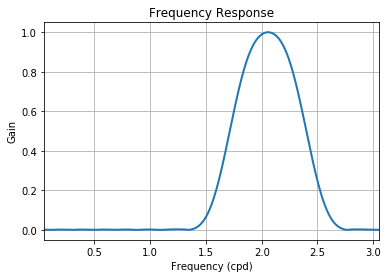

In [7]:
w, hh = signal.freqz(h, worN=8000)
plt.plot((w/np.pi)/2/dt*24, abs(hh), linewidth=2)
plt.xlabel('Frequency (cpd)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.ylim(-0.05, 1.05)
plt.xlim(0.05, 3.05)
plt.grid(True)

In [14]:
def _conv(x):
    return signal.hilbert(im.convolve1d(x, h, axis=2, mode='constant'))

def filt(v):
    return xr.apply_ufunc(_conv, v,
                    dask='parallelized', output_dtypes=[complex],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    output_sizes={'time': len(v.time)})

### filters in the inertial band

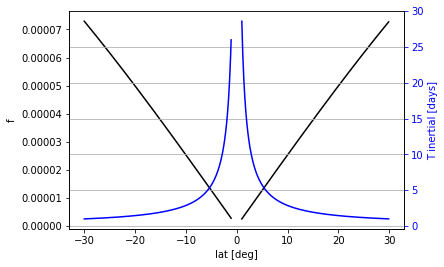

In [6]:
# plot several variables in order to set filtering frequencies
lat = np.arange(-30.,30.,.1)
f = 2*omega_earth*np.sin(np.deg2rad(lat))
f[np.where((lat>-1.)&(lat<1.))]=np.NaN
fig, ax1 = plt.subplots()
ax1.plot(lat, np.abs(f), 'k')
ax1.set_xlabel('lat [deg]')
ax1.set_ylabel('f', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(lat, 2.*np.pi/np.abs(f)/86400, 'b')
ax2.set_ylabel('T inertial [days]', color='b')
ax2.tick_params('y', colors='b')
ax2.grid()

In [11]:
suff = '_inertial'

# latitudinally dependent filtering
def _conv(x, f):
    fmean = np.nanmean(np.abs(f))
    fmean = max(fmean,1e-5) # rad/s
    fmean = fmean/2./np.pi*3600. # rad/s to cph
    df = .1/24 # cpd to cph
    h = signal.firwin(24*10, cutoff=[fmean-df,fmean+df], \
                                  pass_zero=False, nyq=1./2./1., scale=True)
    return signal.hilbert(im.convolve1d(x, h, axis=2, mode='constant'))

def filt(v):
    f = 2*omega_earth*np.sin(np.deg2rad(v['YC'])) # at vorticity points    
    return xr.apply_ufunc(_conv, v, f,
                    dask='parallelized', output_dtypes=[complex],
                    input_core_dims=[['time'],[]],
                    output_core_dims=[['time']],
                    output_sizes={'time': len(v.time)})

---
## load data, grid and 1 face


In [26]:
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>


In [27]:
face = 1

# load data
dsU = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSU',face))
dsV = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSV',face))
dsE = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('Eta',face)) # not on same time line at the moment
ds = xr.merge([dsU.rename({'i_g': 'i'}), dsV.rename({'j_g': 'j'}), dsE], 
              compat='equals').assign_coords(**grd_rspec.sel(face=face))
#
#dsE = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%(v,face))
#ds = dsE.assign_coords(**grd_rspec.sel(face=face))

# spatial subsetting
#ds = ds.isel(i=slice(0,None,dij), j=slice(0,None,dij))

# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

# rechunk along time
ds = ds.chunk({'time': None})

# for plotting purposes
ds = ds.swap_dims({'time':'dtime'}).drop('time').rename({'dtime':'time'})

print(ds)

print('--- face %d done'%face)


dataset size: 1935.2 GB
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 8640)
Coordinates:
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
    face     int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters    (time) int64 dask.array<shape=(8640,), chunksize=(8640,)>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    Depth    (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XC       (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC       (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    mask     (j, i) bool dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
Data variables:
    SSU      (time, j, i) float32 dask.array<shape=(8640, 4320, 4320), chunksize=(8640, 96, 288)>
    SSV      (time, j, i) float32 dask.array<shape=(8640, 4320, 4320), chunksize=(8640, 96, 288)>
    Eta      (time, j, i) float32 dask.arra

--- 

## apply filter

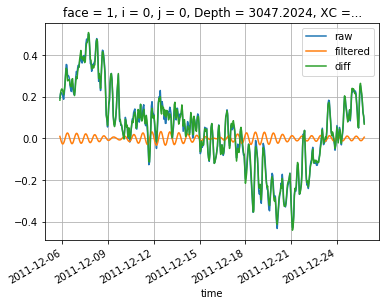

In [28]:
# over a limited area
v='SSU'
#
lv = ds[v].isel(i=slice(5), j=slice(0,100))
lv_f = filt(lv)
#
it = slice(500,500+24*2)
it = slice(500,500+24*20)
ax = plt.subplot(111)
lv.isel(i=0,j=0,time=it).plot(ax=ax,label='raw')
np.real(lv_f).isel(i=0,j=0,time=it).plot(ax=ax,label='filtered')
(lv - np.real(lv_f)).isel(i=0,j=0,time=it).plot(ax=ax,label='diff')
ax.legend()
ax.grid()

In [30]:
# over full data and store
#ds = ds.isel(time=slice(240*2)) # tmp
ds_f = filt(ds[v]).rename(v+suff)

# tmp, xarray zarr backend bug: 
# https://github.com/pydata/xarray/issues/2278
del ds_f['iters'].encoding['chunks']

ds_f = ds_f.to_dataset()
ds_f[v+suff+'_real'], ds_f[v+suff+'_imag'] = np.real(ds_f[v+suff]), np.imag(ds_f[v+suff])
del ds_f[v+suff]
print(ds_f)
%time ds_f.to_zarr(work_data_dir+'filtered/%s%s_%02d.zarr'%(v, suff, face), mode='w')

<xarray.Dataset>
Dimensions:            (i: 4320, j: 4320, time: 8640)
Coordinates:
  * time               (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
    face               int64 1
  * i                  (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    iters              (time) int64 dask.array<shape=(8640,), chunksize=(8640,)>
  * j                  (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    Depth              (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    mask               (j, i) bool dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
Data variables:
    SSU_inertial_real  (j, i, time) float64 dask.array<shape=(4320, 4320, 8640), chunksize=(96, 288, 8640)>
    SSU_inertial_imag  (j, i, time) float64 dask.array<shape=(4320, 4

In [31]:
cluster.close()

---
## make movie

In [6]:
suff = '_inertial'
v = 'SSU'
face=1

In [6]:
# load data
ds = xr.open_zarr(work_data_dir+'filtered/%s%s_%02d.zarr'%(v, suff, face))
#ds = ds.drop('SSU_inertial_imag')
#ds = ds.chunk({'time':240, 'i': None, 'j':None})
ds = ds.chunk({'time':240})
ds

<xarray.Dataset>
Dimensions:            (i: 4320, j: 4320, time: 8640)
Coordinates:
    Depth              (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    face               int64 ...
  * i                  (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    iters              (time) int64 dask.array<shape=(8640,), chunksize=(240,)>
  * j                  (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    mask               (j, i) bool dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
  * time               (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    SSU_inertial_imag  (j, i, time) float64 dask.array<shape=(4320, 4320, 8640), chunksize=(96, 288, 240)>
    SSU_inertial_real  (j, i, time) float64 dask.array<shape=(4320, 4

In [27]:
del ds['iters'].encoding['chunks']
del ds['SSU_inertial_real'].encoding['chunks']
del ds['SSU_inertial_imag'].encoding['chunks']
ds.to_zarr(work_data_dir+'filtered/%s%s_%02d_std.zarr'%(v, suff, face), mode='w')

In [9]:
ds = xr.open_zarr(work_data_dir+'filtered/%s%s_%02d_std.zarr'%(v, suff, face))
ds = ds.chunk({'time': 1, 'i': None, 'j':None})
del ds['iters'].encoding['chunks']
del ds['SSU_inertial_real'].encoding['chunks']
del ds['SSU_inertial_imag'].encoding['chunks']
ds.to_zarr(work_data_dir+'filtered/%s%s_%02d_std_true.zarr'%(v, suff, face), mode='w')

In [10]:
cluster.close()

In [7]:
ds = xr.open_zarr(work_data_dir+'filtered/%s%s_%02d_std_true.zarr'%(v, suff, face))
ds = ds.drop('SSU_inertial_imag')
ds

<xarray.Dataset>
Dimensions:            (i: 4320, j: 4320, time: 8640)
Coordinates:
    Depth              (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    face               int64 ...
  * i                  (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    iters              (time) int64 dask.array<shape=(8640,), chunksize=(1,)>
  * j                  (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    mask               (j, i) int8 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
  * time               (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    SSU_inertial_real  (j, i, time) float64 dask.array<shape=(4320, 4320, 8640), chunksize=(4320, 4320, 1)>

In [8]:
vmin, vmax = -.5, .5

#delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

def genfig(ds, v, i, overwrite=True):
    
    # !! passing a data array does not work, push to xarray
    dv = ds[v]

    #time = dv['time'].values/86400.
    time = dv['time'].values
    figname = figdir+'filtered_%s_f%d_t%05d' %(v, face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #title = '%s %.2f' %(v,time)
        title = '%s %s' %(v, str(time))
        plot_scalar(dv, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='110m', figsize=(15,10), cmmap='balance')
        m = float(dv.mean().values)
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


In [9]:
I = range(len(ds['time']))
#I = range(100)
values = [delayed(genfig)(ds.isel(time=i), v+suff+'_real', i) for i in I]

In [12]:
%time results = client.compute(values)

CPU times: user 7.28 s, sys: 148 ms, total: 7.43 s
Wall time: 7.37 s


In [16]:
results[0]

<Future: status: pending, key: genfig-00066d95-a41e-4b86-967d-3264760aab88>

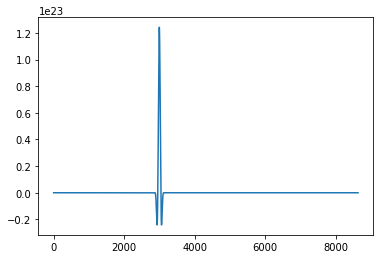

In [18]:
plt.plot(client.gather(results))

In [19]:
cluster.close()

In [ ]:
II = np.array_split(np.arange(len(ds['time'])),10)
#print(II)
for I in II:
    values = [delayed(genfig)(ds.isel(time=i), v+suff+'_real', i) for i in I]
    %time results = client.compute(values).result()

In [16]:
II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/240*4) # 4 maybe will work
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    lds = ds.isel(time=slice(I[0],I[-1]+1)).chunk({'time':1,'i':None,'j':None}).load()
    values = [delayed(genfig)(lds.isel(time=i), v+suff+'_real', I[i]) for i in range(len(I))]    
    %time results = client.compute(values).result()

144 loops to be done
0 - 59
CPU times: user 33.5 s, sys: 19.8 s, total: 53.4 s
Wall time: 53 s
60 - 119
CPU times: user 46 s, sys: 22.9 s, total: 1min 8s
Wall time: 1min 8s
120 - 179


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.135.36.67:43406 remote=tcp://10.135.36.67:39204>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.135.36.67:43404 remote=tcp://10.135.36.67:39204>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.135.36.67:43408 remote=tcp://10.135.36.67:39204>


KeyboardInterrupt: 

180 - 239



KeyboardInterrupt



240 - 299


KeyboardInterrupt: 

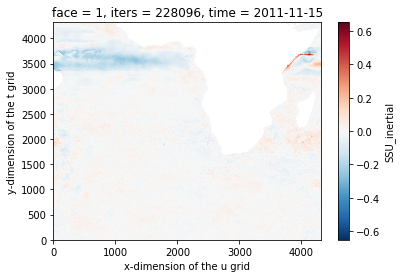

In [18]:
np.real(ds[v+suff]).isel(time=0).plot()

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [ ]:
cluster.close()